## Installing Required Packages

In [1]:
# !pip install earthpy
# !pip install plotly
# !pip install openpyxl
# !pip install rasterio
# !pip install fiona
# !pip install geopandas
# !pip install spyndex
# !pip install rioxarray
# !pip install xarray
# !pip install shap
# !pip install tqdm
# !pip install imbalanced-learn
# !pip install --upgrade xgboost
# !pip install ipympl
# !pip install feature-engine

## Importing Packages

In [3]:
from notebook.services.config import ConfigManager
import warnings
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": True}}})
warnings.filterwarnings("ignore")

In [4]:
from glob import glob
import os, sys
import re
from os import listdir
import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio
import fiona
import rasterio.mask
from rasterio.plot import show
from rasterio import plot as rp
import pandas as pd
import math
import geopandas as gpd
import seaborn as sns
from IPython.display import Image
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numpy as np
import matplotlib
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.metrics import jaccard_score, log_loss, balanced_accuracy_score, make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, GridSearchCV, cross_validate
from tqdm import tqdm
from sklearn import utils
import pickle
from sklearn.svm import SVR
import scipy.stats as stats
import pylab
import scipy.ndimage
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
%matplotlib inline

In [5]:
#function to return plots for the feature
def normality(data,feature):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()

## Import Image and Ground Reference

In [6]:
df = gpd.read_file('./DataShapeFile/Sentinel2_Fishnet_FullData_Point_Nitzanim.shp')
df = df[['Blue','Green','Red','NIR','Area','Class']]
df.dropna(axis=0, inplace=True)
print(df.shape)
df.head(4)

(1360, 6)


,Blue,Green,Red,NIR,Area,Class
0,0.183900,0.227543,0.287468,0.371006,45.597,1
1,0.173047,0.216072,0.264710,0.351969,50.214,1
2,0.186939,0.226398,0.285231,0.367947,23.818,0
3,0.202415,0.247370,0.313151,0.393004,18.964,0


In [7]:
df["Class"].value_counts()

0    823
1    417
2    120
Name: Class, dtype: int64

<AxesSubplot:>

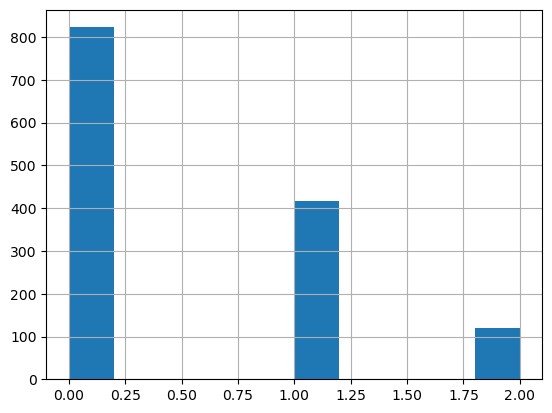

In [8]:
df["Class"].hist()

In [9]:
df.loc[df.Area <= 0, 'Class'] = np.nan
df.dropna(axis=0, inplace=True)
df.loc[df.Area < 60, 'Class'] = 0
df.loc[df.Area >= 60, 'Class'] = 1
df['Class'] = df["Class"].astype('uint8').astype('category')
df["Class"].value_counts()

0    1027
1     169
Name: Class, dtype: int64

In [136]:
# df.loc[df.Area <= 0, 'Class'] = np.nan
# df.loc[df.Area >= 95, 'Class'] = np.nan
# df.dropna(axis=0, inplace=True)
# df["Class"].value_counts()

In [152]:
# df.loc[df.Area >= 50, 'Class'] = 1
# df.loc[df.Area < 50, 'Class'] = 0
# df["Class"].value_counts()

In [ ]:
# df2 = df[df.Area > 10]
# df2 = df2[df2.Area < 1]
# df2["Class"].value_counts()

In [13]:
# data = utils.shuffle(df.groupby("Class").head(500), random_state=8)
df2 = utils.shuffle(utils.shuffle(utils.shuffle(df, random_state=8), random_state=5), random_state=48)
df2 = df2.groupby("Class").sample(160, random_state=10)
# data = utils.shuffle(utils.shuffle(utils.shuffle(data, random_state=8), random_state=5), random_state=48)
# data = data.groupby("Class").sample(200, random_state=21)

# dfnew = utils.shuffle(utils.shuffle(utils.shuffle(df2, random_state=8), random_state=5), random_state=11)
# data = utils.shuffle(dfnew.head(5000), random_state=32)
data = df2[['Blue','Green','Red','NIR','Class']]
# Reset index by dropping old index if not required.
# data.reset_index(drop=True, inplace=True) # Optional step.
# data['Probmean'] = data['Probmean'].round(decimals=3)

In [14]:
(data['Class'].value_counts()) / len(data) * 100

0    50.0
1    50.0
Name: Class, dtype: float64

In [15]:
data

,Blue,Green,Red,NIR,Class
1356,0.137207,0.163776,0.181751,0.296716,0
208,0.123187,0.148481,0.166438,0.254745,0
482,0.143442,0.183594,0.221370,0.307265,0
566,0.153246,0.188648,0.223912,0.303220,0
1198,0.124597,0.147036,0.159571,0.323186,0
...,...,...,...,...,...
685,0.165600,0.210056,0.243856,0.343614,1
914,0.165329,0.208621,0.259377,0.336446,1
875,0.162396,0.201250,0.243258,0.330475,1
564,0.164798,0.196509,0.242243,0.323640,1


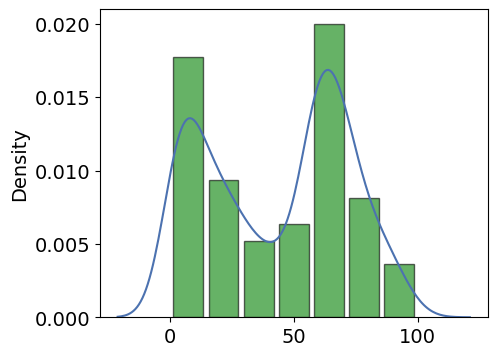

In [140]:
# Plot the distribution of the response variable
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(5,4))
sns.distplot(ax=ax, x=data[['Area']], bins=7, hist_kws={"rwidth":.85,'edgecolor':'black', 'alpha':0.6, 'color':'green'})
# plt.xlabel(plantPro)
# plt.tight_layout()
# plt.savefig(plantPro+'_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

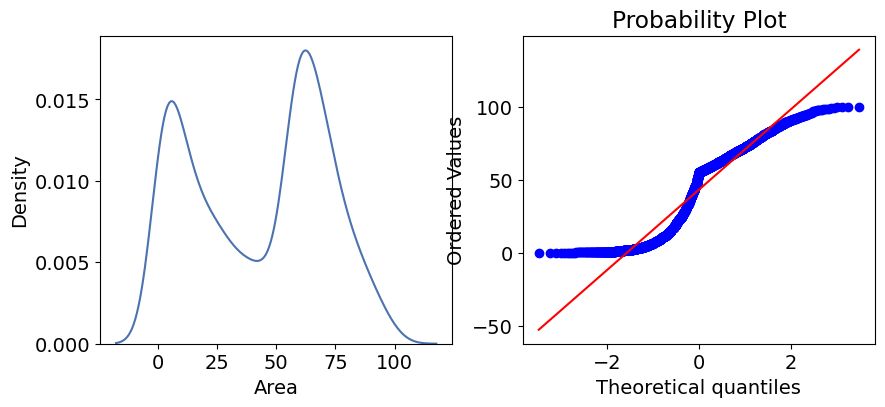

In [85]:
# Q-Q Plot
# stats.probplot(data.Area,plot=pylab)
normality(data,'Area')

In [ ]:
#performing logarithmic transformation on the feature
data['Area']=np.log(data['Area'])

#plotting to check the transformation
normality(data,'Area')

In [ ]:
# for i in np.arange(0, 20, 1):
#     data = utils.shuffle(df.groupby("Class").head(1800), random_state=i)
#     data = data[['Blue','Green','Red','NIR','Class']]
#     X = data.iloc[: , :4]
#     y = data.iloc[: , 4]
#     X = computeIndices(X)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
#     ks2_test = ks_2samp(y_train, y_test)
#     print(str(ks2_test)+'_rs_'+str(i))

In [182]:
data.dropna(axis=0, inplace=True)
print(data.shape)
# data["Class"].value_counts()

(7883, 5)


In [ ]:
# nrows = len(data)
# total_sample_size = 2500
# data.groupby('Class', group_keys=False).apply(lambda x: x.sample(total_sample_size))
# data.groupby('Class', group_keys=False).apply(lambda x: x.sample(int((x.count()/nrows)*total_sample_size)))

In [ ]:
# data = data[['Blue','Green','Red','NIR','Class']]
# data['Probmean'][data['Probmean'] < 0.33] = np.nan
# data.dropna(axis=0, inplace=True)

## Common functions for data preparation and generating results

In [60]:
sns = None
matplotlib.rc_file_defaults()
%matplotlib inline

# Function for classification outcomes
def regressionDetails(model, trainData, trainLabels, y_train_pred, testData, testLabels, predLabels):
    yMax = np.max(trainLabels)
    yMin = np.min(trainLabels)
    print ("Train R2 Score", np.round(r2_score(trainLabels, y_train_pred), 3))
    print ("Test R2 Score", np.round(r2_score(testLabels, predLabels), 3))
    
    # Calculate the rmse for training
    mseTrain = mean_squared_error(trainLabels, y_train_pred)
    rmseTrain = np.sqrt(mseTrain)
    print('Root Mean Square Error (Training): %.3f' % rmseTrain)
    
    # Calculate the rmse for testing
    mseTest = mean_squared_error(testLabels, predLabels)
    rmseTest = np.sqrt(mseTest)
    print('Root Mean Square Error (Testing): %.3f' % rmseTest)
    
    # Calculate the absolute errors for training
    errorsTrain = abs(y_train_pred - trainLabels)

    # Print out the mean absolute error (mae) for training
    print('Mean Absolute Error (For Training):', round(np.mean(errorsTrain), 3))

    # Calculate the absolute errors for testing
    errorsTest = abs(predLabels - testLabels)

    # Print out the mean absolute error (mae) for testing
    print('Mean Absolute Error (For Testing):', round(np.mean(errorsTest), 3))
    
    score_cv = r2_score(testLabels, predLabels)
    z = np.polyfit(testLabels, predLabels, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.scatter(testLabels, predLabels, c='red', edgecolors='k')
        # ax.plot(np.polyval(z, predicted), predicted, c='blue', linewidth=1)
        ax.plot(testLabels, testLabels, color='blue', linewidth=1)
        plt.title('$R^{2}$ (Validation): '+str(np.round(score_cv,3)))
        plt.xlim([0, yMax])
        plt.ylim([0, yMax])
        # plt.legend()
        plt.ylabel('Predicted (%)')
        plt.xlabel('Measured (%)')
        # plt.savefig('Validation_XGB.png', dpi=300, bbox_inches='tight')
        plt.show()
    return

In [61]:
# matplotlib.rc_file_defaults()
%matplotlib inline

# Function for classification outcomes
def classificationDetails2Class(model, trainData, trainLabels, testData, testLabels, predLabels, predProb, modelName):
    
    # Accuracy of the model
    accuracy = accuracy_score(testLabels, predLabels)
    print('Classification Accuracy of the model: {:.2f}%'.format(accuracy*100))
    
    jaccard = jaccard_score(testLabels, predLabels, average=None)
    jaccard = np.round(jaccard, 4)
    print('Jaccard Score of the model: ', jaccard)
    
    ovr_auc = roc_auc_score(testLabels, predProb[:, 1], labels = model.classes_, average = None)
    ovr_auc = np.round(ovr_auc, 4)
    print('ROC AUC (OvR) Score of the model: ', ovr_auc)
    
    # Confusion matrix
    print("Confusion Matrix")
    cm = confusion_matrix(testLabels, predLabels, labels = model.classes_, normalize='true')
    cm = cm * 100
    # target_names = ["Heterotheca", "Outgroup", "Soil"]
    target_names = ["Other", "Heterotheca"]
    # print(matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    # model.classes_
    plt.figure(figsize=(3,3))
    plt.rcParams.update({'font.size': 14})
    disp.plot(cmap=plt.cm.Blues,values_format='.2f')
    plt.tight_layout()
    plt.savefig('./Outputs/Stats/ConfusionMatrix_'+modelName+'.png', dpi = 300, bbox_inches = 'tight')
    
    # Classification Report
    print("\nClassification Report")
    report = classification_report(testLabels, predLabels, target_names=target_names, digits=3)
    print(report)
    report = classification_report(testLabels, predLabels, target_names=target_names, digits=3, output_dict=True)
    report.update({"accuracy": {"precision": None, "recall": None, "f1-score": report["accuracy"], "support": report['macro avg']['support']}})
    report.update({"jaccard": {"precision": None, "recall": jaccard[0], "f1-score": jaccard[1], "support": None}})
    report.update({"OvR_AUC": {"precision": None, "recall": None, "f1-score": ovr_auc, "support": None}})
    reportDF = pd.DataFrame(report).transpose()
    reportDF.to_csv('./Outputs/Stats/classReport_'+modelName+'.csv')
    return

In [62]:
# matplotlib.rc_file_defaults()
%matplotlib inline

# Function for classification outcomes
def classificationDetails3Class(model, trainData, trainLabels, testData, testLabels, predLabels, predProb, modelName):
    
    # Accuracy of the model
    accuracy = accuracy_score(testLabels, predLabels)
    print('Classification Accuracy of the model: {:.2f}%'.format(accuracy*100))
    
    jaccard = jaccard_score(testLabels, predLabels, average=None)
    jaccard = np.round(jaccard, 4)
    print('Jaccard Score of the model: ', jaccard)
    
    ovr_auc = roc_auc_score(testLabels, predProb, labels = model.classes_, multi_class = 'ovr', average = None)
    ovr_auc = np.round(ovr_auc, 4)
    print('ROC AUC (OvR) Score of the model: ', ovr_auc)
    
    # Confusion matrix
    print("Confusion Matrix")
    target_names = ["Low", "Moderate", "High"]
    cm = confusion_matrix(testLabels, predLabels, labels = model.classes_, normalize='true')
    cm = cm * 100
    # print(matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    # model.classes_
    plt.figure(figsize=(3,3))
    plt.rcParams.update({'font.size': 14})
    disp.plot(cmap=plt.cm.Blues,values_format='.2f')
    plt.tight_layout()
    plt.savefig('./Outputs/Stats/ConfusionMatrix_'+modelName+'.png', dpi = 300, bbox_inches = 'tight')
    
    # Classification Report
    print("\nClassification Report")
    report = classification_report(testLabels, predLabels, target_names=target_names, digits=3)
    print(report)
    report = classification_report(testLabels, predLabels, target_names=target_names, digits=3, output_dict=True)
    report.update({"accuracy": {"precision": None, "recall": None, "f1-score": report["accuracy"], "support": report['macro avg']['support']}})
    report.update({"jaccard": {"precision": jaccard[0], "recall": jaccard[1], "f1-score": jaccard[2], "support": None}})
    report.update({"OvR_AUC": {"precision": ovr_auc[0], "recall": ovr_auc[1], "f1-score": ovr_auc[2], "support": None}})
    reportDF = pd.DataFrame(report).transpose()
    reportDF.to_csv('./Outputs/Stats/classReport_'+modelName+'.csv')
    return

In [63]:
def applyFullImageRegression(imageName, datasetType, model, modelName):
    # Image loading and size checking
    img_val = rio.open(imageName+'.tif')
    tiff_extent = [img_val.bounds[0], img_val.bounds[2], img_val.bounds[1], img_val.bounds[3]]
    print('Image bands', img_val.count)
    print('Image crs: ', img_val.crs)
    rows = img_val.height
    cols = img_val.width
    noBandsVal = img_val.count
    im1 = img_val.read(1)
    
    # Converting image to dataframe
    img_r = []
    for i in range(1, noBandsVal+1):
        temp = img_val.read(i)
        img_r.append(temp)

    img_r = np.stack(img_r, axis=0)
    
    if noBandsVal == 11:
        img_df = pd.DataFrame(img_r.reshape([noBandsVal,-1]).T, 
                          columns=['B1','Blue','Green','Red','B5','B6','B7', 'NIR','B8A','B11','B12'])
    elif noBandsVal == 4:
        img_df = pd.DataFrame(img_r.reshape([noBandsVal,-1]).T, 
                          columns=['Blue','Green','Red','NIR'])
    
    img_df = img_df[['Blue','Green','Red','NIR']]
    img_df = img_df.replace(np.nan, np.nan)
    img_df = img_df.replace(-1, np.nan)
    img_df = img_df.replace(0, np.nan)
    
    if datasetType == '4Bands':
        img_df = img_df
    else:
        img_df = computeIndices(img_df)
    
    img_df = img_df.replace(0, np.nan)
    img_df = img_df.replace(np.nan, -1)
    
    # Predict Area Cover
    
    y_pred_prob = model.predict(img_df)
    
    def apply_mask_border(img, gt):
        img = np.where(gt == np.nan, np.nan, img)
        img = np.where(gt == -1, np.nan, img)
        img = np.where(gt == 0, np.nan, img)
        return img
        
    y_pred_prob_reshape = y_pred_prob.reshape(1, rows, cols)
    y_pred_prob_reshape = apply_mask_border(y_pred_prob_reshape, im1)
    
    metaprob = img_val.meta.copy()
    metaprob.update({'count':1})
    metaprob.update({'dtype':'float32'})
    metaprob.update({'nodata':np.nan})
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,9), tight_layout=True)
    show(img_val, ax=ax1, extent=tiff_extent , transform=img_val.transform)
    show(y_pred_prob_reshape, ax=ax2, extent=tiff_extent , transform=img_val.transform)
    plt.show()
    
    outprobfilename = './Outputs/Images/' + imageName + '_' + datasetType + '_' + modelName + '_Prob.tif'
    with rio.open(outprobfilename, 'w', **metaprob) as outprob:
        outprob.write(y_pred_prob_reshape)
    return

In [64]:
def applyFullImageClassification(imageName, datasetType, model, modelName):
    # Image loading and size checking
    img_val = rio.open(imageName+'.tif')
    tiff_extent = [img_val.bounds[0], img_val.bounds[2], img_val.bounds[1], img_val.bounds[3]]
    print('Image bands', img_val.count)
    print('Image crs: ', img_val.crs)
    rows = img_val.height
    cols = img_val.width
    noBandsVal = img_val.count
    im1 = img_val.read(1)
    
    # Converting image to dataframe
    img_r = []
    for i in range(1, noBandsVal+1):
        temp = img_val.read(i)
        img_r.append(temp)

    img_r = np.stack(img_r, axis=0)
    
    if noBandsVal == 11:
        img_df = pd.DataFrame(img_r.reshape([noBandsVal,-1]).T, 
                          columns=['B1','Blue','Green','Red','B5','B6','B7', 'NIR','B8A','B11','B12'])
    elif noBandsVal == 4:
        img_df = pd.DataFrame(img_r.reshape([noBandsVal,-1]).T, 
                          columns=['Blue','Green','Red','NIR'])
    
    img_df = img_df[['Blue','Green','Red','NIR']]
    img_df = img_df.replace(np.nan, np.nan)
    img_df = img_df.replace(-1, np.nan)
    img_df = img_df.replace(0, np.nan)
    
    if datasetType == '4Bands':
        img_df = img_df
    else:
        img_df = computeIndices(img_df)
    
    img_df = img_df.replace(0, np.nan)
    img_df = img_df.replace(np.nan, -1)
    
    # Predict probability (3 bands generated)
    # band 0 - Other
    # band 1 - Heterotheca
    # band 2 - Heterotheca
    
    y_pred_prob = model.predict_proba(img_df)
    
    def apply_mask_border(img, gt):
        img = np.where(gt == np.nan, np.nan, img)
        img = np.where(gt == -1, np.nan, img)
        img = np.where(gt == 0, np.nan, img)
        return img
        
    y_pred_prob_reshape = np.zeros((3, rows, cols))
    y_pred_prob_reshape[0, :, :] = y_pred_prob[:,0].reshape(rows, cols)
    y_pred_prob_reshape[1, :, :] = y_pred_prob[:,1].reshape(rows, cols)
    y_pred_prob_reshape[2, :, :] = y_pred_prob[:,1].reshape(rows, cols)
    
    for i in range(0, 3):
        y_pred_prob_reshape[i, :, :] = apply_mask_border(y_pred_prob_reshape[i, :, :], im1)
    
    metaprob = img_val.meta.copy()
    metaprob.update({'count':3})
    metaprob.update({'dtype':'float32'})
    metaprob.update({'nodata':np.nan})
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,9), tight_layout=True)
    show(img_val, ax=ax1, extent=tiff_extent , transform=img_val.transform)
    show(y_pred_prob_reshape, ax=ax2, extent=tiff_extent , transform=img_val.transform)
    plt.show()
    
    outprobfilename = './Outputs/Images/' + imageName + '_' + datasetType + '_' + modelName + '_Prob.tif'
    with rio.open(outprobfilename, 'w', **metaprob) as outprob:
        outprob.write(y_pred_prob_reshape)
    return

In [65]:
def plot_feature_importance(importance, names, model_type, modelName):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(8,6))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.savefig('./Outputs/Stats/FeatureImportance_'+modelName+'.png', dpi = 300, bbox_inches = 'tight')
    return

In [16]:
def computeIndices(df):
    df1 = df[['Blue', 'Green', 'Red', 'NIR']]
    # df1 = df[['Blue', 'Green', 'Red']]
    # df1['SlopeGB'] = df["Green"] - df["Blue"]
    # df1['NDVI'] = (df["NIR"] - df["Red"]) / (df["NIR"] + df["Red"])
    df1['NDYI'] = (df["Green"] - df["Blue"])/(df["Green"] + df["Blue"])
    df1['SAVI'] = (2 * (df["NIR"] - df["Red"])) / (df["NIR"] + df["Red"] + 1)
    # df1['VDVI'] = (2 * df["Green"] - df["Red"] - df["Blue"]) / (2 * df["Green"] + df["Red"] + df["Blue"])
    # df1['MGRVI'] = (np.power(df["Green"], 2) - np.power(df["Red"], 2)) / (np.power(df["Green"], 2) + np.power(df["Red"], 2))
    df1['EBI'] = (df[["Blue", "Green", "Red"]].sum(axis=1)) / ((df["Green"] / df["Blue"]) * (df["Red"] - df["Blue"] + 1))
    # df1['GNDVI'] = (df["NIR"] - df["Green"]) / (df["NIR"] + df["Green"])
    df1['BI'] = np.power(((np.power(df["Red"], 2) + np.power(df["Green"],2) + np.power(df["Blue"],2))/3),0.5)
    df1['NBRRI'] = (df["Red"] - df["Blue"])/(df["Red"] + df["Blue"])
    # Blue-wide dynamic range vegetation index (BWDRVI)
    # df1['SI'] = (df["Red"] - df["Blue"])/(df["Red"] + df["Blue"])
    # Saturation index has same formula as NBRRI, hence we are using NBRRI
    # hsv = matplotlib.colors.rgb_to_hsv(df[['Red','Green','Blue']])
    # hsv = np.round(hsv, 6)
    # hsv = pd.DataFrame(hsv, index=df.index, columns=['Hue', 'Saturation', 'Value'])
    # df1 = pd.concat([df1, hsv[['Hue', 'Saturation']]], axis=1)
    # df1 = pd.concat([df1, hsv[['Saturation']]], axis=1)
    return df1

## Correlation amongst factors

In [ ]:
import seaborn as sns

testDF = computeIndices(data.loc[:, data.columns != "Class"])
pearsoncorr = testDF.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, 
           yticklabels=pearsoncorr.columns, 
           cmap='RdBu_r', annot=True,linewidth=0.5)
plt.savefig('CorrelationPlot_Factors_Sentinel2.png', bbox_inches='tight', dpi=300, transparent=False)

## Train - Test Split

In [18]:
X_train

,Blue,Green,Red,NIR,NDYI,SAVI,EBI,BI,NBRRI
80,0.152116,0.188431,0.229874,0.322473,0.106637,0.119302,0.427264,0.192776,0.203560
108,0.247834,0.318197,0.384729,0.485443,0.124309,0.107706,0.651351,0.321811,0.216413
29,0.126985,0.155577,0.177533,0.267706,0.101188,0.124786,0.357469,0.154755,0.165993
160,0.189384,0.233163,0.283696,0.357499,0.103607,0.089938,0.524200,0.238547,0.199357
241,0.144324,0.182860,0.219036,0.296446,0.117781,0.102159,0.401139,0.184611,0.205614
...,...,...,...,...,...,...,...,...,...
295,0.155739,0.196349,0.239358,0.314310,0.115340,0.096484,0.432920,0.200083,0.211642
125,0.152749,0.185551,0.219320,0.306872,0.096961,0.114733,0.430391,0.187850,0.178921
131,0.188781,0.223726,0.290403,0.358305,0.084714,0.082370,0.538405,0.238065,0.212073
221,0.136336,0.163598,0.197707,0.279235,0.090893,0.110401,0.390734,0.167770,0.183722


In [17]:
dfnew = data
dfnew.reset_index(drop=True, inplace=True)

X = dfnew.iloc[: , :4]
y = dfnew.iloc[: , 4]

withIndices = input('Do you want indices ? (y/n)')
if withIndices == 'y':
    X = computeIndices(X)
    datasetType = str(X.shape[1]) + 'Bands'
else:
    datasetType = '4Bands'
    X = X

# noNewBands = shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=7)

# X_train, X_test, y_train, y_test = scsplit(X, y, stratify = y, test_size=0.3, random_state=12)

# Two-sample Kolmogorov-Smirnov test for checking the train and test distribution
ks2_test = ks_2samp(y_train, y_test)
print(ks2_test)

train_test_data = './Outputs/TrainTestData/' + datasetType + '_train_test_data_newTrained.xlsx'
output_results = './Outputs/TrainTestData/' + datasetType + 'Output_Predicted.xlsx'

# with pd.ExcelWriter(train_test_data, engine="openpyxl") as writer:
#     tempTrnDF = pd.concat([X_train, y_train], axis=1)
#     tempTrnDF.to_excel(writer, sheet_name='TrainData', index=True, header=True)
#     tempTstDF = pd.concat([X_test, y_test], axis=1)
#     tempTstDF.to_excel(writer, sheet_name='TestData', index=True, header=True)
# writer=None

Do you want indices ? (y/n) y


KstestResult(statistic=0.0, pvalue=1.0)


In [224]:
# dfnew = data
# dfnew.reset_index(drop=True, inplace=True)
# X = dfnew.iloc[: , :4]
# y = dfnew.iloc[: , 4]
# X = computeIndices(X)
# for i in np.arange(0,25,1):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
#     ks2_test = ks_2samp(y_train, y_test)
#     print(str(ks2_test)+'_RS_'+str(i))

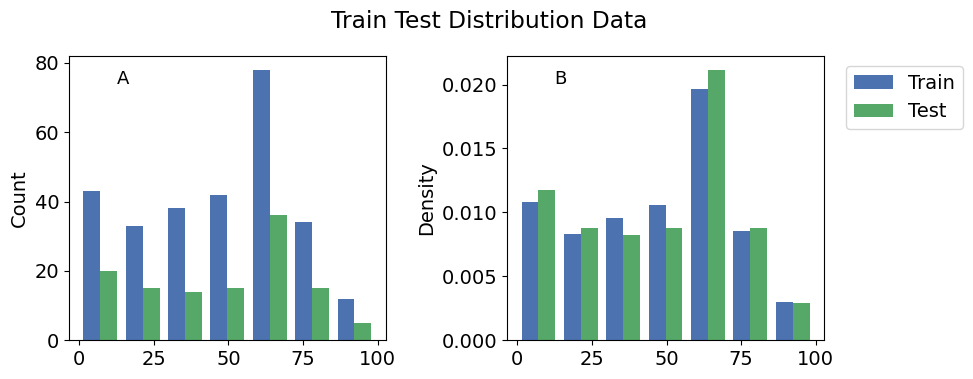

In [277]:
## Train Test Distribution
%matplotlib inline
plt.style.use('seaborn-deep')
minValue = np.min(y)
maxValue = np.max(y)

fig, ax = plt.subplots(1,2, figsize=(10,4))
bins = np.linspace(minValue,maxValue,8)

ax[0].hist([y_train, y_test], bins , label=['Train', 'Test'])
# ax[0].legend(loc='upper right')
# ax[0].set_xlabel(plantPro)
ax[0].set_ylabel('Count')
ax[0].text(0.15, 0.95, 'A' , transform = ax[0].transAxes, fontsize =13, verticalalignment = 'top')

ax[1].hist([y_train, y_test], bins , label=['Train', 'Test'], density=True)
# ax[1].legend(loc='upper right')
# ax[1].set_xlabel(plantPro)
ax[1].set_ylabel('Density')
ax[1].text(0.15, 0.95, 'B' , transform = ax[1].transAxes, fontsize =13, verticalalignment = 'top')

plt.subplots_adjust(bottom=0.2, top =0.88, right = 0.84, left =0.12 )
# plt.subplot_tool()
fig.suptitle('Train Test Distribution Data', x = 0.5 ,y = .95)
plt.legend(bbox_to_anchor = (1.47,1))
plt.tight_layout()
# plt.savefig('TrainTestDistribution_RS_5.png', dpi= 300, bbox_inches='tight')
plt.show()

In [68]:
# Test Image Name
# imageName = 'S2_Image_2022-11-06_Coast'
imageName = 'S2_Image_2022-11-06_Coast_warp'

# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test, y_test)]

## Basic Random Forest

In [90]:
clf = RandomForestClassifier(n_estimators=80, max_depth=4, n_jobs=-1, random_state = 10)
# clf = SVC(probability=True)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=3)
# n_estimators=100, max_depth=4, 
# evaluate model

clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, n_estimators=80, n_jobs=-1, random_state=10)

In [91]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)
y_train_pred = clf.predict(X_train)
modelName = input("Input model name for saving results")

Input model name for saving results Model_RF_noHPT_newTrained


In [ ]:
# Performance of Validation
regressionDetails(clf, X_train, y_train, y_train_pred, X_test, y_test, y_pred)

Classification Accuracy of the model: 72.92%
Jaccard Score of the model:  [0.5806 0.5667]
ROC AUC (OvR) Score of the model:  0.8043
Confusion Matrix

Classification Report
              precision    recall  f1-score   support

       Other      0.720     0.750     0.735        48
 Heterotheca      0.739     0.708     0.723        48

    accuracy                          0.729        96
   macro avg      0.730     0.729     0.729        96
weighted avg      0.730     0.729     0.729        96



<Figure size 300x300 with 0 Axes>

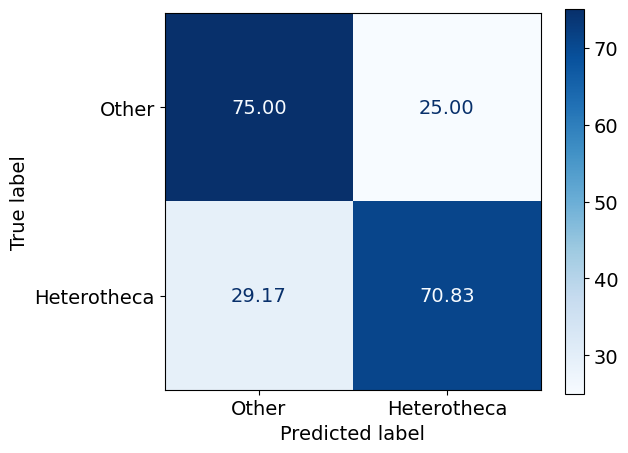

In [92]:
# Classification Results
classificationDetails2Class(clf, X_train, y_train, X_test, y_test, y_pred, y_proba, datasetType + '_' + modelName)

In [93]:
# Pickle Save
dumpName = './Outputs/Models/' + datasetType + '_' + modelName + '.pkl'
pickle.dump(clf, open(dumpName, 'wb'))

# Load trained model
# clf = pickle.load(open(dumpName, 'rb'))
# y_pred = clf.predict(X_test)

Image bands 4
Image crs:  EPSG:32636


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


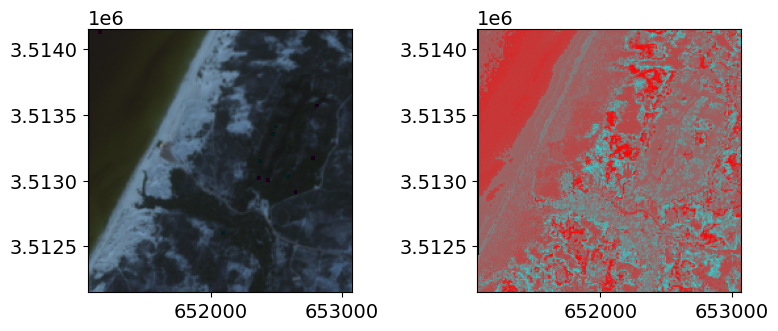

In [94]:
# Apply basic model on full image
# matplotlib.rc_file_defaults()
import seaborn as sns
# applyFullImageClassification(imageName, datasetType, clf, modelName+'NotUSed')
applyFullImageClassification(imageName, datasetType, clf, modelName)
# OvR_ROC(clf, X_test, y_test, y_proba, datasetType, modelName)

## Feature Importance

In [26]:
feature_list = list(X_train.columns)
print('Feature List', feature_list)
importances = list(clf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature List ['Blue', 'Green', 'Red', 'NIR', 'NDYI', 'SAVI', 'EBI', 'BI', 'NBRRI']
Variable: NBRRI                Importance: 0.16
Variable: NDYI                 Importance: 0.15
Variable: Green                Importance: 0.14
Variable: NIR                  Importance: 0.1
Variable: EBI                  Importance: 0.1
Variable: BI                   Importance: 0.1
Variable: Blue                 Importance: 0.09
Variable: SAVI                 Importance: 0.09
Variable: Red                  Importance: 0.06


<Figure size 400x300 with 0 Axes>

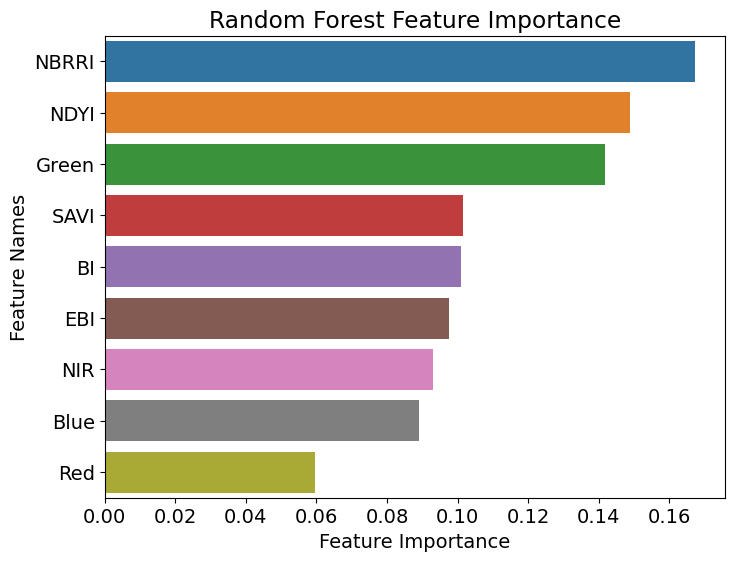

In [100]:
import seaborn as sns
plt.figure(figsize=(4,3))
plot_feature_importance(clf.feature_importances_,X.columns,'Random Forest ', modelName)
# sns = None
# matplotlib.rc_file_defaults()

In [ ]:
# importance = clf.feature_importances_
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

%matplotlib inline
# Set the style
# fig, ax = plt.subplots(figsize=(6, 4))
plt.figure(figsize=(7,5))
plt.style.use('fivethirtyeight')

# list of index locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.tight_layout()

## RF Hyperparameter Tuning

In [101]:
rf_base = RandomForestClassifier(random_state=10, n_jobs=-1)

n_estimators = [int(x) for x in np.arange(30, 100, 5)]
max_depth = [int(x) for x in np.linspace(2, 4, num = 3)]
max_features = ['log2', 'sqrt']
min_samples_split = [3, 5, 8, 10]
bootstrap = [True, False]
criterion=['gini', 'entropy', 'log_loss']

random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'criterion': criterion,\
               'max_features':max_features, 'min_samples_split':min_samples_split,\
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95], 'max_depth': [2, 3, 4], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['log2', 'sqrt'], 'min_samples_split': [3, 5, 8, 10], 'bootstrap': [True, False]}


In [102]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

scoring = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = random_grid,
                               n_iter=300, cv = cv, error_score='raise', random_state=10,
                               scoring = scoring, verbose=1, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 15 folds for each of 300 candidates, totalling 4500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
                   error_score='raise',
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=10),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 3, 4],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_split': [3, 5, 8, 10],
                                        'n_estimators': [30, 35, 40, 45, 50, 55,
                                                         60, 65, 70, 75, 80, 85,
                                                         90, 95]},
                   random_state=10,
                   scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
                   verbose=1)

In [103]:
print(rf_random.best_params_)
y_pred = rf_random.predict(X_test)
y_train_pred = rf_random.predict(X_train)
y_proba = rf_random.predict_proba(X_test)
modelName = input("Input model name for saving results")

{'n_estimators': 75, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'log_loss', 'bootstrap': True}


Input model name for saving results Model_RF_HPT_newTrained


In [104]:
bestmodel = rf_random.best_estimator_
rf_new = RandomForestClassifier(n_estimators=bestmodel.n_estimators, 
                                max_depth=bestmodel.max_depth, 
                                criterion= bestmodel.criterion, 
                                max_features= bestmodel.max_features, random_state=10, n_jobs=-1)
rf_new.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=4, n_estimators=75,
                       n_jobs=-1, random_state=10)

<Figure size 400x300 with 0 Axes>

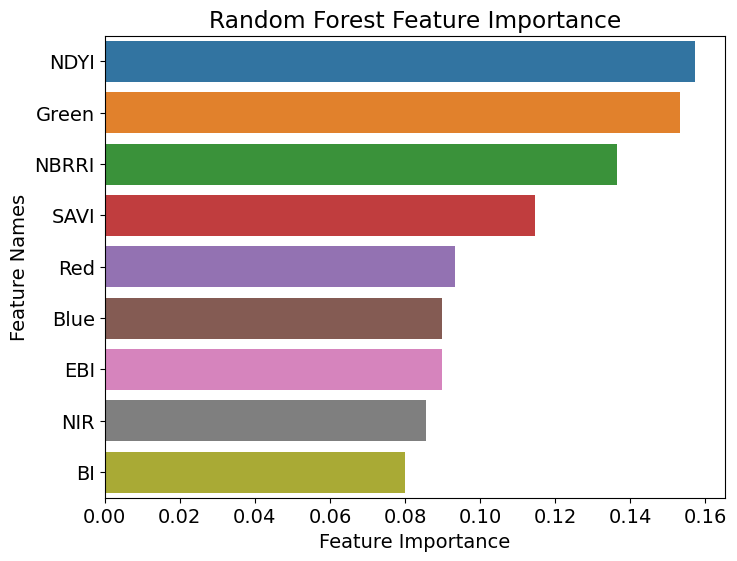

In [105]:
import seaborn as sns
plt.figure(figsize=(4,3))
plot_feature_importance(rf_new.feature_importances_,X.columns,'Random Forest ', modelName)
# sns = None
# matplotlib.rc_file_defaults()

Classification Accuracy of the model: 73.96%
Jaccard Score of the model:  [0.5902 0.5833]
ROC AUC (OvR) Score of the model:  0.7969
Confusion Matrix

Classification Report
              precision    recall  f1-score   support

       Other      0.735     0.750     0.742        48
 Heterotheca      0.745     0.729     0.737        48

    accuracy                          0.740        96
   macro avg      0.740     0.740     0.740        96
weighted avg      0.740     0.740     0.740        96



<Figure size 300x300 with 0 Axes>

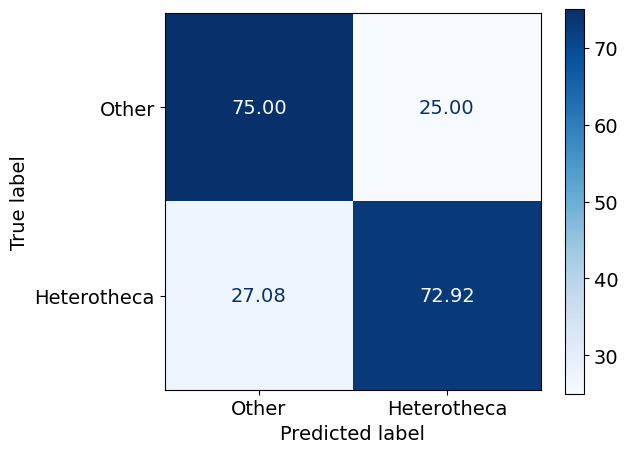

In [107]:
# Classification Results
matplotlib.rc_file_defaults()
classificationDetails2Class(rf_random, X_train, y_train, X_test, y_test, y_pred, y_proba, datasetType + '_' + modelName)

In [108]:
# Pickle Save
dumpName = './Outputs/Models/' + datasetType + '_' + modelName + '.pkl'
pickle.dump(rf_random, open(dumpName, 'wb'))

# Load trained model
# rf_random = pickle.load(open(dumpName, 'rb'))
# y_pred = rf_random.predict(X_test)

Image bands 4
Image crs:  EPSG:32636


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


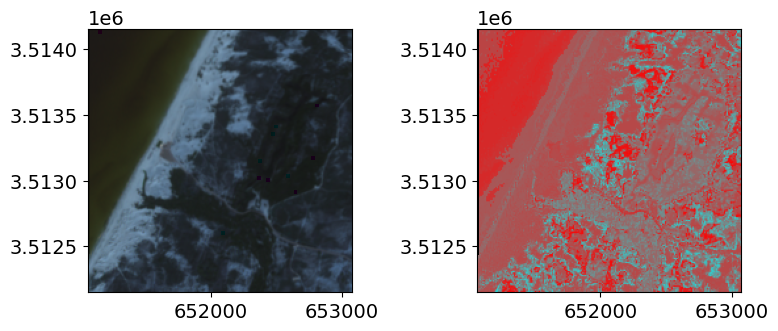

In [109]:
# Apply basic model on full image
# matplotlib.rc_file_defaults()
import seaborn as sns
applyFullImageClassification(imageName, datasetType, rf_random, modelName)
# OvR_ROC(rf_random, X_test, y_test, y_proba, datasetType, modelName)

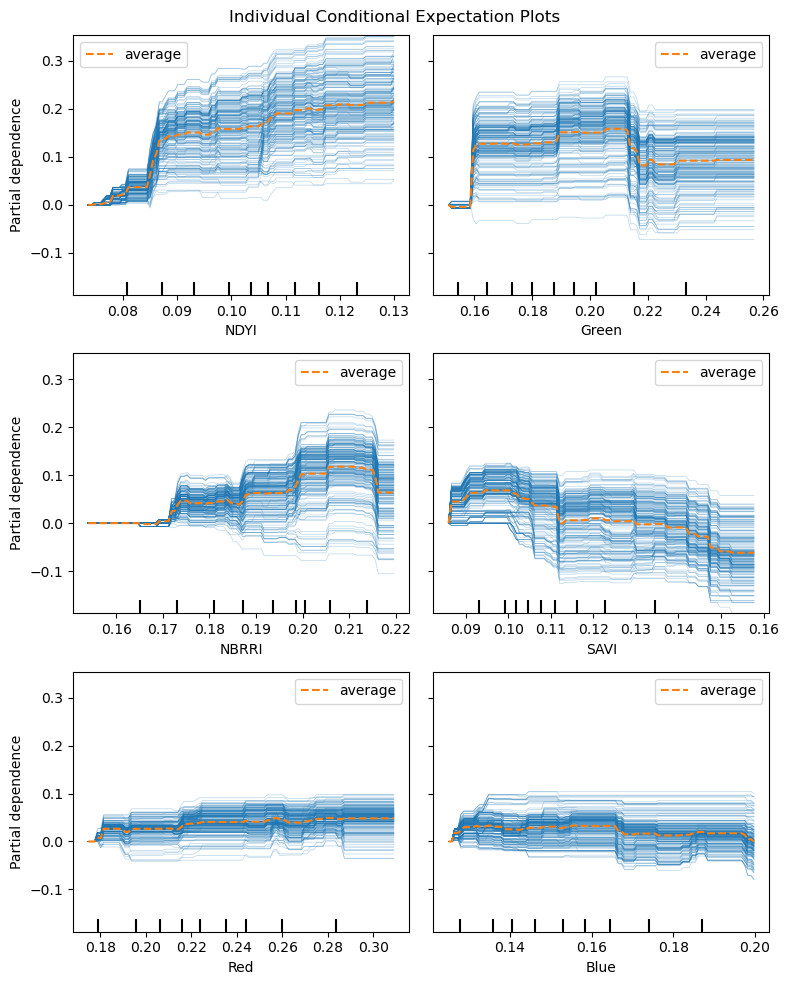

In [19]:
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay)
modelName = 'Model_RF_HPT'
# Load trained model
rf_random = pickle.load(open('./Outputs/Models/9Bands_Model_RF_HPT_newTrained.pkl', 'rb'))

var = ['NDYI', 'Green', 'NBRRI', 'SAVI', 'Red', 'Blue']#, 'Saturation', 'NDYI', 'MGRVI']

n_cols = 2
n_rows = int(len(var)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(8, 10))
PartialDependenceDisplay.from_estimator(rf_random, X_train, var, target=0,\
                                        ax=ax, n_cols=n_cols, kind='both', centered=True, n_jobs=-1)
# PartialDependenceDisplay.from_estimator(rf_random, X_train, var, target=0, line_kw={"color": "red"},\
#                                         ax=ax, n_cols=n_cols, centered=True, n_jobs=-1)
# fig.suptitle('Partial Dependence Plots')
fig.suptitle('Individual Conditional Expectation Plots')
fig.tight_layout()

# plt.savefig('./Outputs/PDP_'+modelName+'.png', dpi=300, bbox_inches='tight')
plt.savefig('./Outputs/ICE_'+modelName+'.png', dpi=300, bbox_inches='tight')

In [117]:
y_train.value_counts()

0    112
1    112
Name: Class, dtype: int64

In [118]:
y_test.value_counts()

0    48
1    48
Name: Class, dtype: int64

In [285]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [286]:
y_pred = lin_reg.predict(X_test)
y_train_pred = lin_reg.predict(X_train)

Train R2 Score 0.327
Test R2 Score 0.259
Root Mean Square Error (Training): 21.039
Root Mean Square Error (Testing): 22.577
Mean Absolute Error (For Training): 17.538
Mean Absolute Error (For Testing): 18.572


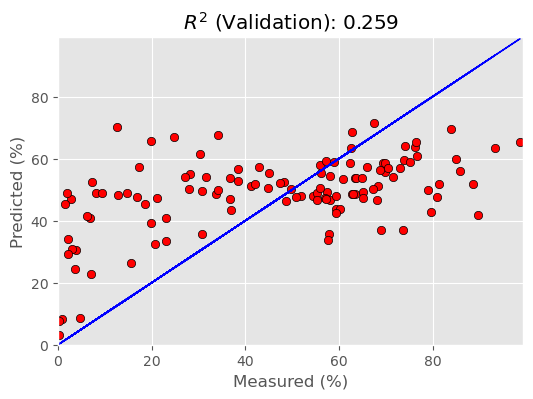

In [287]:
# Regression Results

regressionDetails(lin_reg, X_train, y_train, y_train_pred, X_test, y_test, y_pred)

## Apply on Full images
- Parallel Processing

In [110]:
fishnet_DF = gpd.read_file('./Prediction_Shapefile/S2_Fishnet_FullWarp_Image_FullFinal.shp')
# fishnet_DF.set_index('Id')
fishnet_DF.shape

(279446, 6)

In [111]:
# Function for applying classification results on all images

def applyShapeFile(df, model):
    df = df[['Blue','Green','Red','NIR']]
    df = computeIndicesShapefile(df)
        
    # Predict probability (2 columns generated)
    # band 0 - Other
    # band 1 - Heterotheca
    
    y_pred_prob = model.predict_proba(df)
    y_pred_prob = pd.DataFrame(y_pred_prob, columns = ['Other','Heterotheca'])
    y_pred_prob.index = df.index
    return y_pred_prob

def computeIndicesShapefile(df):
    df1 = df[['Blue', 'Green', 'Red', 'NIR']]
    # df1 = df[['Blue', 'Green', 'Red']]
    # df1['SlopeGB'] = df["Green"] - df["Blue"]
    # df1['NDVI'] = (df["NIR"] - df["Red"]) / (df["NIR"] + df["Red"])
    df1['NDYI'] = (df["Green"] - df["Blue"])/(df["Green"] + df["Blue"])
    df1['SAVI'] = (2 * (df["NIR"] - df["Red"])) / (df["NIR"] + df["Red"] + 1)
    # df1['VDVI'] = (2 * df["Green"] - df["Red"] - df["Blue"]) / (2 * df["Green"] + df["Red"] + df["Blue"])
    # df1['MGRVI'] = (np.power(df["Green"], 2) - np.power(df["Red"], 2)) / (np.power(df["Green"], 2) + np.power(df["Red"], 2))
    df1['EBI'] = (df[["Blue", "Green", "Red"]].sum(axis=1)) / ((df["Green"] / df["Blue"]) * (df["Red"] - df["Blue"] + 1))
    # df1['GNDVI'] = (df["NIR"] - df["Green"]) / (df["NIR"] + df["Green"])
    df1['BI'] = np.power(((np.power(df["Red"], 2) + np.power(df["Green"],2) + np.power(df["Blue"],2))/3),0.5)
    df1['NBRRI'] = (df["Red"] - df["Blue"])/(df["Red"] + df["Blue"])
    # df1['SI'] = (df["Red"] - df["Blue"])/(df["Red"] + df["Blue"])
    # Saturation index has same formula as NBRRI, hence we are using NBRRI
    # hsv = matplotlib.colors.rgb_to_hsv(df[['Red','Green','Blue']])
    # hsv = np.round(hsv, 6)
    # hsv = pd.DataFrame(hsv, index=df.index, columns=['Hue', 'Saturation', 'Value'])
    # df1 = pd.concat([df1, hsv[['Hue', 'Saturation']]], axis=1)
    # df1 = pd.concat([df1, hsv[['Saturation']]], axis=1)
    return df1

In [112]:
# Load trained model
rf_random = pickle.load(open('./Outputs/Models/9Bands_Model_RF_HPT_newTrained.pkl', 'rb'))

In [113]:
testDF = fishnet_DF[['Blue','Green','Red','NIR']]
testedDF = applyShapeFile(testDF, rf_random)
finalDF = pd.concat([fishnet_DF, testedDF], axis=1)

In [114]:
# Export Shapefile
finalDF.to_file('./Prediction_Shapefile/Sentinel2_Fishnet_Predicted_RF_HPT_newTrained.shp', driver='ESRI Shapefile')  

In [ ]:
# Function for applying classification results on all images

def applyFullImageFolder(address):
    model = rf_random
    modelName = 'Model_RF_HPT'
    datasetType = '13Bands'
    output_dir = os.path.dirname('./S2_Images/')
    # Image loading and size checking
    head, tail = os.path.split(address)
    fname, fext = os.path.splitext(tail)
    img_val = rio.open(address)
    tiff_extent = [img_val.bounds[0], img_val.bounds[2], img_val.bounds[1], img_val.bounds[3]]
    print('Image bands', img_val.count)
    print('Image crs: ', img_val.crs)
    rows = img_val.height
    cols = img_val.width
    noBandsVal = img_val.count
    im1 = img_val.read(1)
    
    # Converting image to dataframe
    img_r = []
    for i in range(1, noBandsVal+1):
        temp = img_val.read(i)
        img_r.append(temp)

    img_r = np.stack(img_r, axis=0)
    
    if noBandsVal == 11:
        img_df = pd.DataFrame(img_r.reshape([noBandsVal,-1]).T, 
                          columns=['B1','Blue','Green','Red','B5','B6','B7', 'NIR','B8A','B11','B12'])
    elif noBandsVal == 4:
        img_df = pd.DataFrame(img_r.reshape([noBandsVal,-1]).T, 
                          columns=['Blue','Green','Red','NIR'])
    
    img_df = img_df[['Blue','Green','Red','NIR']]
    img_df = img_df.replace(np.nan, np.nan)
    img_df = img_df.replace(-1, np.nan)
    img_df = img_df.replace(0, np.nan)
    
    if datasetType == '4Bands':
        img_df = img_df
    else:
        img_df = computeIndices(img_df)
    
    img_df = img_df.replace(0, np.nan)
    img_df = img_df.replace(np.nan, -1)
    
    # Predict probability (3 bands generated)
    # band 0 - Other
    # band 1 - Heterotheca
    # band 2 - Heterotheca
    
    y_pred_prob = model.predict_proba(img_df)
    
    def apply_mask_border(img, gt):
        img = np.where(gt == np.nan, np.nan, img)
        img = np.where(gt == -1, np.nan, img)
        img = np.where(gt == 0, np.nan, img)
        return img
        
    y_pred_prob_reshape = np.zeros((3, rows, cols))
    y_pred_prob_reshape[0, :, :] = y_pred_prob[:,0].reshape(rows, cols)
    y_pred_prob_reshape[1, :, :] = y_pred_prob[:,1].reshape(rows, cols)
    y_pred_prob_reshape[2, :, :] = y_pred_prob[:,1].reshape(rows, cols)
    
    for i in range(0, 3):
        y_pred_prob_reshape[i, :, :] = apply_mask_border(y_pred_prob_reshape[i, :, :], im1)
    
    metaprob = img_val.meta.copy()
    metaprob.update({'count':3})
    metaprob.update({'dtype':'float32'})
    metaprob.update({'nodata':np.nan})
    
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,9), tight_layout=True)
    # show(img_val, ax=ax1, extent=tiff_extent , transform=img.transform)
    # show(y_pred_val_reshape, ax=ax2, extent=tiff_extent , transform=img.transform)
    # show(y_pred_prob_reshape, ax=ax3, extent=tiff_extent , transform=img.transform)
    # plt.show()
    
    output_file = fname + '_' + datasetType + '_' + modelName + '_Prob.tif'
    outprobfilename = os.path.join(output_dir, output_file)
    with rio.open(outprobfilename, 'w', **metaprob) as outprob:
        outprob.write(y_pred_prob_reshape)
    return None

In [ ]:
from multiprocessing import Pool
import os
import time

input_dir = os.path.dirname('./S2_Images/')
pathFolder = sorted(glob.glob(input_dir + r'/*.tif'))

def main():
    workers = os.cpu_count()
    with Pool(workers) as p:
        p.map(applyFullImageFolder, pathFolder)
        p.close()
if __name__ == '__main__':
    main()

## Zipping Results

In [2]:
import os
import zipfile    

def zipit(folders, zip_filename):
    zip_file = zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED)

    for folder in folders:
        for dirpath, dirnames, filenames in os.walk(folder):
            for filename in filenames:
                zip_file.write(
                    os.path.join(dirpath, filename),
                    os.path.relpath(os.path.join(dirpath, filename), os.path.join(folders[0], '../..')))

    zip_file.close()

folders = ["DataShapeFile", "Input_Images", "Outputs", "Prediction_Shapefile", "S2_Images"]

zipit(folders, "Sentinel_Image_Results.zip")